# Entrenamiento

In [4]:
import numpy as np 
import pandas as pd
import joblib
import os

In [19]:
models_results = {}

### Cargado de datos

In [23]:
for i in range(1, 8):
    file_name_train = f'../data/dataFrame_final/final_train/df_final_train_{i}.csv'
    globals()[f'df_train_{i}'] = pd.read_csv(file_name_train, encoding='ISO-8859-1')
    print(f'Archivo {file_name_train} cargado en df_train_{i}')

    file_name_test = f'../data/dataFrame_final/final_test/df_final_test_{i}.csv'
    globals()[f'df_test_{i}'] = pd.read_csv(file_name_test, encoding='ISO-8859-1')
    print(f'Archivo {file_name_test} cargado en df_test_{i}')

Archivo ../data/dataFrame_final/final_train/df_final_train_1.csv cargado en df_train_1
Archivo ../data/dataFrame_final/final_test/df_final_test_1.csv cargado en df_test_1
Archivo ../data/dataFrame_final/final_train/df_final_train_2.csv cargado en df_train_2
Archivo ../data/dataFrame_final/final_test/df_final_test_2.csv cargado en df_test_2
Archivo ../data/dataFrame_final/final_train/df_final_train_3.csv cargado en df_train_3
Archivo ../data/dataFrame_final/final_test/df_final_test_3.csv cargado en df_test_3
Archivo ../data/dataFrame_final/final_train/df_final_train_4.csv cargado en df_train_4
Archivo ../data/dataFrame_final/final_test/df_final_test_4.csv cargado en df_test_4
Archivo ../data/dataFrame_final/final_train/df_final_train_5.csv cargado en df_train_5
Archivo ../data/dataFrame_final/final_test/df_final_test_5.csv cargado en df_test_5
Archivo ../data/dataFrame_final/final_train/df_final_train_6.csv cargado en df_train_6
Archivo ../data/dataFrame_final/final_test/df_final_test_6

### Normalización


Es necesaria normalización para Redes neuronales y recomendada para Regresión Logística, SVM, Regresión Lineal y Polinomial

### Definición de funciones

In [42]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import SGDRegressor
import numpy as np
from sklearn.linear_model import SGDClassifier

In [ ]:
!pip3.12 install dask dask-ml joblib

In [70]:
# Recibe un modelo entrenado y realiza una predicción sobre los conjuntos de entrenamiento y test para evaluarlo
def evaluate_model(X, y, model, model_name):
        
    raw_predictions = model.predict(X)
    if model_name == 'LinearRegression':
        predictions = [round(x) for x in raw_predictions]
        average = 'macro'
    else:
        predictions = raw_predictions 
        average = 'binary'
    accuracy = metrics.accuracy_score(y, predictions)
    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(
        y, predictions, average=average, zero_division=0
    )
    train_auc = metrics.roc_auc_score(y, predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': fscore,
        'auc': train_auc,
        'num_samples': len(y)  
    }
    


In [74]:
def prediction(model, model_name):
    results_list = {
        'train': [],
        'test': []
    }

    for i in range(1, 8):
        data_train = globals()[f'df_train_{i}']
        X_train = data_train.drop(columns=['label']).values
        y_train = data_train['label'].values

        data_test = globals()[f'df_test_{i}']
        X_test = data_test.drop(columns=['label']).values
        y_test = data_test['label'].values

        train_partition_results = evaluate_model(X_train, y_train, model, model_name)
        results_list['train'].append(train_partition_results)

        test_partition_results = evaluate_model(X_test, y_test, model, model_name)
        results_list['test'].append(test_partition_results)

    # Guardar resultados de cada partición en models_results
    models_results[f'{model_name}'] = results_list


In [65]:
import matplotlib.pyplot as plt

def plot_results(model_name):
    train_f1_scores = [result['f1_score'] for result in models_results[f'{model_name}']['train']]
    test_f1_scores = [result['f1_score'] for result in models_results[f'{model_name}']['test']]

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 8), train_f1_scores, label='Train F1 Score', marker='o', color='blue')
    plt.plot(range(1, 8), test_f1_scores, label='Test F1 Score', marker='o', color='red')
    plt.title(f'Comparación de F1 en {model_name}')
    plt.xlabel('Número de partición')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()


In [96]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_comparison(models_results, metric='accuracy'):
    models = list(models_results.keys())
    train_scores = []
    test_scores = []
    
    for model in models:
        train_metric = np.mean([entry[metric] for entry in models_results[model]['train']])
        test_metric = np.mean([entry[metric] for entry in models_results[model]['test']])
        
        train_scores.append(train_metric)
        test_scores.append(test_metric)
    
    x = np.arange(len(models))
    width = 0.25  

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width/2, train_scores, width, label='Train')
    ax.bar(x + width/2, test_scores, width, label='Test')

    ax.set_xlabel('Models')
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'{metric.capitalize()} by model')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45)
    ax.legend()

    plt.tight_layout()
    plt.show()



### Regresión Lineal DONE

##### Entrenamiento

Como LinealRegression no permite hacer partial fit, usamos SGDRegressor con loss = squared error y así realiza lo mismo que el original, minimizar el error cuadrático

In [44]:
model = SGDRegressor(loss='squared_error', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values
    
    model.partial_fit(X_train, y_train)


In [45]:
dir = "../data/models"
model_path = os.path.join(dir, "LinearRegression.joblib")
joblib.dump(model, model_path)

['../data/models\\LinearRegression.joblib']

##### Predicción

In [78]:
# Cargar modelo de LinearRegression
model = joblib.load("../data/models/LinearRegression.joblib")

In [79]:
prediction(model, 'LinearRegression')

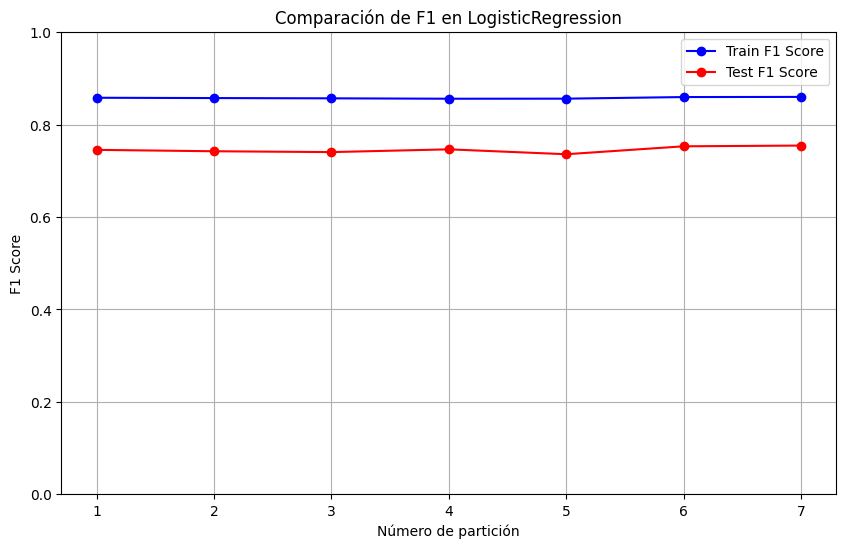

In [80]:
plot_results('LogisticRegression')

### Regresión Polinomial

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

# Creamos el pipeline de regresión polinomial
polynomial_model = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('linear_regression', LinearRegression())
])

# Evaluamos y guardamos el resultado
results_dict['PolynomialRegression'] = evaluate_model(X_train, X_test, y_train, y_test, polynomial_model, 'PolynomialRegression')


### Regresión Logística: DONE

##### Entrenamiento

Como LinearRegression no permite un entrenamiento por partes, usamos SGDClasifier en su lugar con "loss='log'" para realizar una clasificación utilizando el algoritmo de gradiente descendente estocástico.

In [24]:
model = SGDClassifier(loss='log_loss', random_state=42)

for i in range(1, 8):
    data_train = globals()[f'df_train_{i}']
    X_train = data_train.drop(columns=['label']).values
    y_train = data_train['label'].values

    model.partial_fit(X_train, y_train, classes=np.unique(y_train))


In [25]:
dir = "../data/models"
model_path = os.path.join(dir, "LogisticRegression.joblib")
joblib.dump(model, model_path)


['../data/models\\LogisticRegression.joblib']

##### Predicción

In [71]:
# Cargar modelo de LogisticRegression
model = joblib.load("../data/models/LogisticRegression.joblib")

In [76]:
prediction(model, 'LogisticRegression')

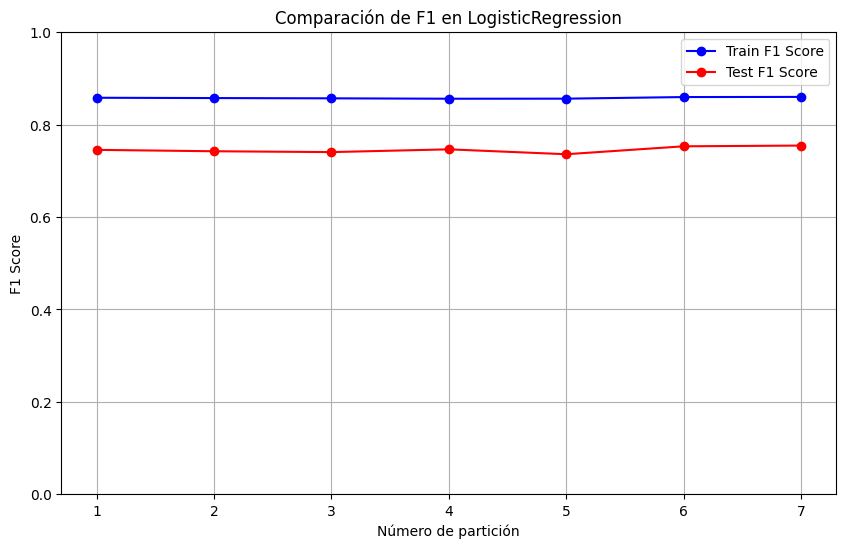

In [77]:
plot_results('LogisticRegression')

### Árboles de decisión

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Modelo de Árbol de Decisión
tree_model = DecisionTreeClassifier()

# Evaluamos y guardamos el resultado
results_dict['DecisionTree'] = evaluate_model(X_train, X_test, y_train, y_test, tree_model, 'DecisionTree')


### Basado en instancias : KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Modelo de K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)

# Evaluamos y guardamos el resultado
results_dict['KNeighbors'] = evaluate_model(X_train, X_test, y_train, y_test, knn_model, 'KNeighbors')


### Máquinas de soporte vectorial : SVC

In [ ]:
from sklearn.svm import SVC

# Modelo de SVM
svm_model = SVC(kernel='rbf', probability=True)

# Evaluamos y guardamos el resultado
results_dict['SVM'] = evaluate_model(X_train, X_test, y_train, y_test, svm_model, 'SVM')


### Redes neuronales 

In [ ]:
from sklearn.neural_network import MLPClassifier

# Modelo de Red Neuronal
nn_model = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)

# Evaluamos y guardamos el resultado
results_dict['NeuralNetwork'] = evaluate_model(X_train, X_test, y_train, y_test, nn_model, 'NeuralNetwork')


## Comparación de resultados

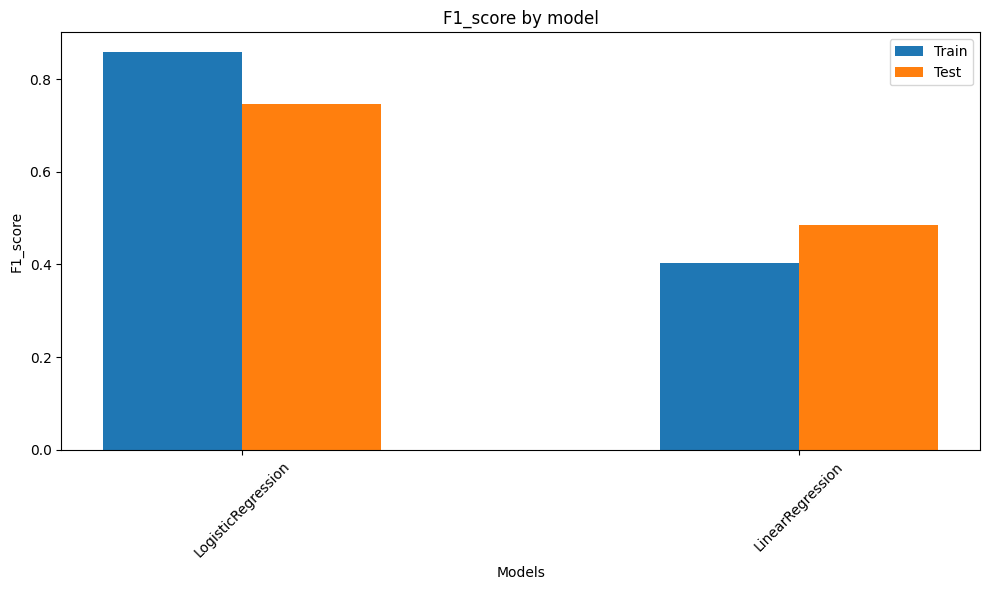

In [ ]:
plot_model_comparison(models_results, metric='f1_score')

## Ajuste de hiperparámetros

## Nuevos resultados